# Model and Dataset

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from skimage.color import gray2rgb, rgb2gray, label2rgb
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [2]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5, padding = 1),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim = 1)
        )

    def forward(self, x): 
        x = self.conv_layers(x)
#         print (x.shape)
        x = x.view(-1, 500)
        x = self.fc_layers(x)
        return x



In [3]:
batch_size = 64
test_batch_size = 1000
epochs = 20
lr = .1
gamma = 0.7
use_cuda = torch.cuda.is_available()
seed = 10
log_interval = 10
save_model = True
Train_Flag = False

In [4]:
torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

transform=transforms.Compose([
    transforms.ToTensor(),
    lambda x: torch.cat ([x,x,x]) #Converting to 3 channels
#     transforms.Normalize((0.1307,), (0.3081,))
    ])


In [5]:

dataset_train = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset_test = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset_train,batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset_test, test_batch_size, shuffle = True)

In [6]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss()

In [7]:


def train(model, epoch, train_loader, optimizer, criterion, verbose = True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, epoch, test_loader, criterion, verbose = True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output.log(), target).item() * len (data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            acc))
    return acc
        

In [8]:

if Train_Flag:
    scheduler = StepLR(optimizer, step_size=5, gamma=gamma)
    for epoch in range(1, epochs + 1):
        train(model, epoch, train_loader, optimizer, criterion)
        test(model, epoch, test_loader, criterion)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "ckpt.pth")
else:
    model.load_state_dict (torch.load("ckpt.pth"))
    epoch = 0
    acc = test (model, 0, test_loader, criterion, verbose = False)
    print ("loaded pretrained model with", acc, "% accuracy on test images")


loaded pretrained model with 98.71 % accuracy on test images


In [9]:
def filter_mask(mask, topp = 0.2):
    mask_torch = mask
    if isinstance (mask , np.ndarray):
        mask_torch = torch.tensor(mask)
    mask_linear = mask_torch.reshape(-1)
    _, mask_sortedargs = mask_linear.sort()
    mask_ones = torch.ones(len(mask_linear))
    mask_ones[:int(len(mask_linear) * (1-topp))] = 0.0
    mask_linear = mask_ones[mask_sortedargs.argsort()]
    
    return mask_linear.reshape(mask.shape)

class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, masks):
        self.data = data
        self.labels = labels
        self.masks = masks
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        filtered_mask = filter_mask (self.masks[idx])
        img = img * filtered_mask

        return img, label
def generate_masked_dataset(dataset, mask_generator, max_iters = 100, model = model):
    masks = []
    images = []
    labels = []
    if max_iters is not None:
        max_iters = min(max_iters, len(dataset))
    else:
        max_iters = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, 1, shuffle = True)
    for i, (x,y) in tqdm (enumerate (dataloader), total = max_iters):
        x, y = x[0], y[0]
        images.append(x)
        labels.append(y)    
        mask = mask_generator(x, y, model)
        masks.append(mask)
        if i > max_iters:
            break
    return MaskedDataset(images, labels, masks)


# lime

In [10]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [11]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(torch.tensor (i).permute([2,0,1]) for i in images), dim=0)

    if (batch.dtype == torch.float64):
        batch = batch.to(torch.float32)  

    if (batch.dtype == torch.uint8):
        batch = batch.float()/255     

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
#     logits = model(batch)
    probs = model(batch)
    return probs.detach().cpu().numpy()

In [27]:
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=1,
                                        max_dist=20, ratio=0.9,
                                        random_seed=100)

def limeExplanation(img, model):
    # img shape: [C, H, W]
    img = img.permute ([1,2,0]).to(torch.float64).numpy()
    explainer = lime_image.LimeImageExplainer(verbose = False)
    explanation = explainer.explain_instance(img, 
                                             batch_predict, # classification function
                                             top_labels=3, 
                                             hide_color=0, 
                                             num_samples=100, segmentation_fn=segmentation_fn) # number of images that will be sent to classification function
    
    mask_on_img, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features = 3, hide_rest=False)
    img_boundry2 = mark_boundaries(mask_on_img, mask)
    return mask, img_boundry2, mask_on_img

def plotrow(ax, idx, img, mask, img_boundry2, mask_on_img):
    if isinstance(img, torch.Tensor):
        img = img.permute ([1,2,0]).numpy()

    ax[idx,0].imshow(img)
    ax[idx,0].set_title("Input")
    ax[idx,0].axis('off')

    ax[idx,1].imshow(mask)
    ax[idx,1].set_title("mask")
    ax[idx,1].axis('off')

    ax[idx,2].imshow(mask_on_img)
    ax[idx,2].set_title("mask on iamge")
    ax[idx,2].axis('off')

    ax[idx,3].imshow(img_boundry2)
    ax[idx,3].set_title("mask boundaries")
    ax[idx,3].axis('off')

In [28]:
imgs,labels = next (iter (test_loader))

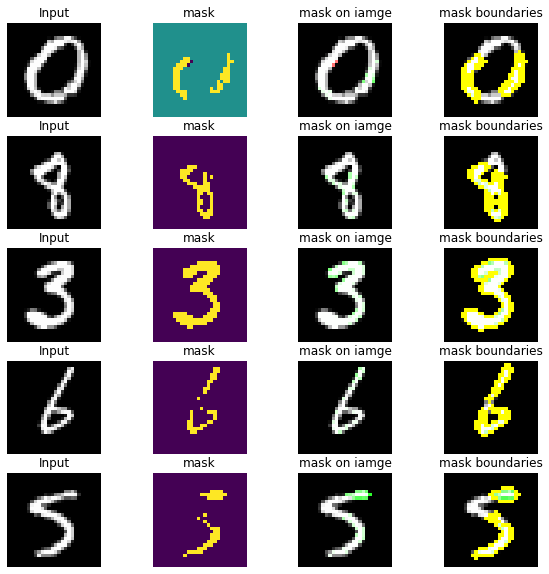

In [29]:


fig, ax = plt.subplots(5,4, figsize=(10, 10))
for i in range(5):
    img = imgs[i]
    label = labels[i].item()
    mask, img_boundry2, mask_on_img = limeExplanation(img, model)
    plotrow(ax, i, img, mask, img_boundry2, mask_on_img)

plt.show()

In [14]:
dataset_test_lime = generate_masked_dataset(dataset_test, mask_generator = lambda x, y, model : limeExplanation(x, model)[0])

In [15]:
test_loader_lime = torch.utils.data.DataLoader(dataset_test_lime, test_batch_size, shuffle = True)
test(model, epoch, test_loader_lime, criterion, verbose = True)


Test set: Average loss: 0.0916, Accuracy: 100/102 (98%)



98.03921568627452

# Shapley (GradientExplainer)

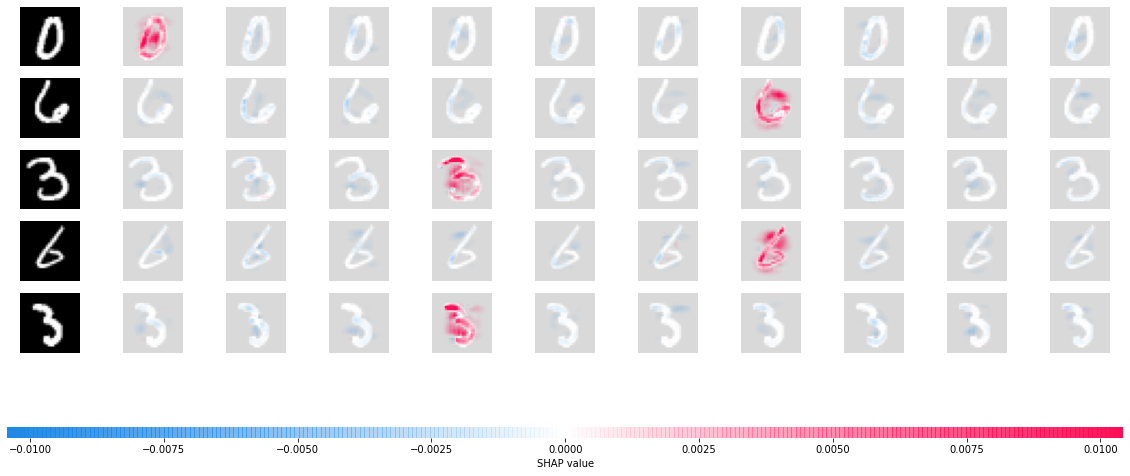

In [16]:
import shap
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)
model.eval()

test_batch_size = len(images)

background = images[:test_batch_size-5]
test_images = images[test_batch_size-5:]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)


# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

In [17]:
def shapExplanation(x,y,model):
    shap_values = e.shap_values(x[None].to(device))
    torch.cuda.empty_cache()
    return torch.tensor(shap_values[y][0])

In [18]:
dataset_test_shap = generate_masked_dataset(dataset_test, shapExplanation, max_iters = 20)

In [19]:
test_loader_shap = torch.utils.data.DataLoader(dataset_test_shap, test_batch_size, shuffle = True)
test(model, epoch, test_loader_shap, criterion, verbose = True)


Test set: Average loss: 0.0138, Accuracy: 22/22 (100%)



100.0

# LRP

In [20]:

def convert_to_lrp(model):
    new_model = torch.nn.ModuleList([])
    for l in model.conv_layers:
        if isinstance(l,torch.nn.Conv2d):
            new_model.append(lrp.Conv2d.from_torch(l))

        else:
            new_model.append(l)
    new_model.append(torch.nn.Flatten())
    for l in model.fc_layers:
        if isinstance(l,torch.nn.Linear):
            new_model.append(lrp.Linear.from_torch(l))
        elif isinstance(l,torch.nn.Softmax):
            continue
        else:
            new_model.append(l)
    new_model = lrp.Sequential(*new_model).to(device)
    return new_model

In [21]:
import lrp
from visualization import project, clip_quantile, heatmap_grid, grid
from lrp.patterns import fit_patternnet, fit_patternnet_positive # PatternNet patterns


In [22]:
model_lrp = convert_to_lrp(model)

In [23]:
patterns = fit_patternnet_positive(model_lrp, train_loader, device=device)

100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 119.89it/s]


In [24]:

batch = next(iter(test_loader))
x, y = batch
x = x[:6]
y = y[:6]

x = x.to(device)
x = x.requires_grad_(True)

batch_to_append = batch[0][:31].clone()
batch_to_append = batch_to_append
batch_to_append = batch_to_append.requires_grad_(True)


In [25]:
def LRPMask(x, model_lrp, rule, patterns):
    x = x.to(device)
    x = x.detach()
    x.requires_grad_(True)
    
    # Forward pass
    y_hat_lrp = model_lrp.forward(x, explain=True, rule=rule, pattern=patterns)

    # Choose argmax
    y_hat_lrp = y_hat_lrp[torch.arange(x.shape[0]), y_hat_lrp.max(1)[1]]
    y_hat_lrp = y_hat_lrp.sum()

    # Backward pass (compute explanation)
    y_hat_lrp.backward()
    attr = x.grad    
    return attr

def compute_and_plot_explanation(x, model_lrp, rule, ax_, patterns=None, plt_fn=heatmap_grid): 
    
    attr = LRPMask(x, model_lrp, rule, patterns)

    # Plot
    attr = plt_fn(attr)
    ax_.imshow(attr)
    ax_.set_title(rule)
    ax_.axis('off')
# PatternNet is typically handled a bit different, when visualized.
def signal_fn(X):
    if X.shape[1] in [1, 3]: X = X.permute(0, 2, 3, 1).detach().cpu().numpy()
    X = clip_quantile(X)
    X = project(X)
    X = grid(X)
    return X

def lrpExplanation(x, y, model):
    return LRPMask(torch.cat ([x[None],batch_to_append]), model, rule = 'alpha1beta0', patterns = None)[0].cpu()

Plotting


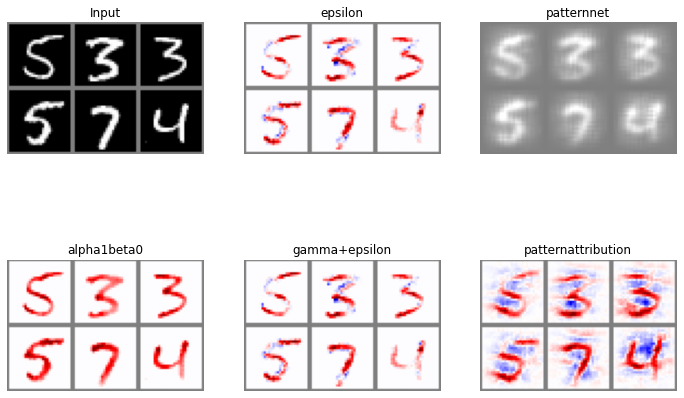

In [26]:
explanations = [
        # rule                  Pattern     plt_fn          Fig. pos
        ('alpha1beta0',         None,       heatmap_grid,   (1, 0)), 
        ('epsilon',             None,       heatmap_grid,   (0, 1)), 
        ('gamma+epsilon',       None,       heatmap_grid,   (1, 1)), 
        ('patternnet',          patterns,   signal_fn,      (0, 2)),
        ('patternattribution',  patterns,   heatmap_grid,   (1, 2)),
    ]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
print("Plotting")

# Plot inputs
input_to_plot = x.permute(0, 2, 3, 1).contiguous().detach().cpu().numpy()
input_to_plot = grid(input_to_plot, 3, 1.)
ax[0, 0].imshow(input_to_plot)
ax[0, 0].set_title("Input")
ax[0, 0].axis('off')

# Plot explanations
for i, (rule, pattern, fn, (p, q) ) in enumerate(explanations): 
    compute_and_plot_explanation(x, model_lrp, rule, ax[p, q], patterns=pattern, plt_fn=fn)



In [27]:
dataset_test_lrp = generate_masked_dataset(dataset_test, lrpExplanation, max_iters=400, model = model_lrp)

In [28]:
test_loader_lrp = torch.utils.data.DataLoader(dataset_test_lrp, test_batch_size, shuffle = True)
test(model, epoch, test_loader_lrp, criterion, verbose = True)


Test set: Average loss: 0.0486, Accuracy: 394/402 (98%)



98.00995024875621

In [29]:
def normalize_and_permute(x):
    no = (x - x.min()) / (x.max() - x.min())
    if len(no.shape) == 3:
        no = no.permute([1,2,0])
    return no

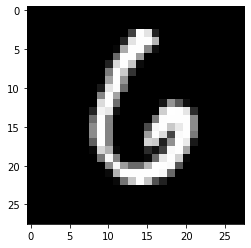

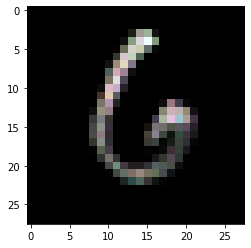

In [30]:
plt.imshow (normalize_and_permute(dataset_test_lrp.data[10]), cmap = "gray")
plt.show()
plt.imshow (normalize_and_permute(dataset_test_lrp.masks[10]), cmap = "gray")
plt.show()